## Imports

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
from scipy.interpolate import griddata

import h5py
from scipy.integrate import quadrature
from scipy.stats import chi2
import pickle
import pandas as pd

from plots import scientific_format, dmu_idm_dr, plot_observations, plot_varied_recoupling
from data_generation.variables import *
from scipy.signal import argrelextrema
from scipy.stats import chisquare

import seaborn as sns

from observation_data.observations import *

from pathos.multiprocessing import ProcessingPool as Pool
import itertools
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')


/Users/nolansmyth/opt/anaconda3/envs/kinetic_recoupling/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# h5pydir = '/Users/nolansmyth/Dropbox/kinetic_recoupling/h5py_dat/'
h5pydir = 'h5py_dat/'

# h5pydir = '<YOUR PATH HERE>Dropbox/kinetic_recoupling/h5py_dat/'

In [4]:
plt.style.use("/Users/nolansmyth/Dropbox/kinetic_recoupling/figures/style.mplstyle")
# plt.style.use("<YOUR PATH HERE>Dropbox/kinetic_recoupling/figures/style.mplstyle")

In [37]:
pk_sd_interp = pickle.load(open("interps/pks_sd_interp.p", "rb"))
pk_dd_interp = pickle.load(open("interps/pks_dd_interp.p", "rb"))
pk_strong_interp = pickle.load(open("interps/pks_strong_interp.p", "rb"))
pk_strong_interp_late = pickle.load(open("interps/pks_strong_interp_late.p", "rb"))
best_fits_saved = np.load("./interps/best_fit_sds.npz")
best_a_dimless_arr = best_fits_saved["best_a_dimless_arr"]

pk_strong_interp_n2 = pickle.load(open("interps/pks_strong_interp_n2.p", "rb"))

In [6]:
#Get data for case with no recoupling
k = '1.0'
data_file=h5pydir+'class_testing_no_rec.hdf5'
with h5py.File(data_file, 'r') as f:
    tau_data = np.array(f['scalar']['k='+str(k)]['tau [Mpc]'])
    delta_chi_data = np.array(f['scalar']['k='+str(k)]['delta_idm_dr'])
    phi_data = np.array(f['scalar']['k='+str(k)]['phi'])
    theta_dr_data = np.array(f['scalar']['k='+str(k)]['theta_idr'])
    theta_data = np.array(f['scalar']['k='+str(k)]['theta_idm_dr'])
    
    
    delta_chi_no_rec = UnivariateSpline(tau_data, delta_chi_data, **spline_pars)
    delta_chi_dot_no_rec = delta_chi_no_rec.derivative()
    phi_no_rec = UnivariateSpline(tau_data, phi_data, **spline_pars)
    phi_dot_no_rec = phi_no_rec.derivative()
    theta_dr_no_rec = UnivariateSpline(tau_data, theta_dr_data, **spline_pars)

    theta_chi_no_rec = UnivariateSpline(tau_data, theta_data, **spline_pars)
    theta_chi_dot_no_rec = theta_chi_no_rec.derivative()

    Pks_no_rec = np.array(f['power_spectrum']['Pk'])
    kks_no_rec = np.array(f['power_spectrum']['kk'])

    kappa_dot_data_no_rec = np.flip(np.array(f['thermodynamics']['dmu_idm_dr']))
    z_data_no_rec = np.flip(np.array(f['thermodynamics']['z']))
    thermo_tau_data_no_rec = np.flip(np.array(f['thermodynamics']['conf. time [Mpc]']))

    rho_idr_no_rec = np.array(f['background']['(.)rho_idr'])
    rho_idm_no_rec = np.array(f['background']['(.)rho_idm_dr'])
    bkg_zs_no_rec = np.array(f['background']['z'])
    clTT_no_rec = np.array(f['cmb']['tt'])
    ll_no_rec = np.array(f['cmb']['ell'])

    thermo_taus_no_rec = UnivariateSpline(np.flip(z_data_no_rec), np.flip(thermo_tau_data_no_rec), **spline_pars)

    a_data = 1/(1+z_data_no_rec)
    a = UnivariateSpline(thermo_tau_data_no_rec, a_data, **spline_pars)
    aprime = a.derivative()
def conformal_H(z):
    return aprime(thermo_taus_no_rec(z))/a(thermo_taus_no_rec(z))

In [43]:
def plot_varied_recoupling_strong(Tr0, Ar0, Tr1, Ar1, save=False):
    """
    Plot the interpolation between two scenarios with varied 
    recoupling temperature and/or strength (1,2).
    Normalized to the first scenario (0), presumably no recoupling.
    """

    zs = np.logspace(5, 8, 1000)
    dmus1 = [dmu_idm_dr(Tr1, Ar1, z) for z in zs]

    fig = plt.figure(1, figsize=(8, 8))
    plt.subplot(211)
    plt.plot(
        kk,
        # pk_strong_interp((Tr1, Ar1, kk)) / pk_dd_interp((Tr0, Ar0, kk)),
        pk_strong_interp_late((Tr1, Ar1, kk)) / pk_dd_interp((Tr0, Ar0, kk)),

        "b",
        label="$T_\mathrm{rec}$=%s eV, $A_\mathrm{rec}$=%s"
        % (scientific_format(Tr1 * ktoev), scientific_format(Ar1)),
    )
    
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(1e-1, 3e1)
    # plt.ylim(0.97, 1)
    plt.xlabel("k [h/Mpc]")
    plt.ylabel("$P(k)/P(k)_0$")
    plt.legend()
    plt.title("Double Decoupling")
    plt.subplot(212)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("z")
    plt.ylabel("$\Gamma_{\mathrm{DR-DM}}$")
    plt.plot(
        zs,
        dmus1,
        "b",
        label="$T_\mathrm{rec}$=%s eV, $A_\mathrm{rec}$=%s"
        % (scientific_format(Tr1 * ktoev), scientific_format(Ar1)),
    )
    
    plt.plot(np.logspace(5, 8, 100), 1e-3 * np.ones(100), "--k")
    plt.plot(np.logspace(5, 8, 100), np.ones(100), "--k")

    plt.xlim(zs[0], zs[-1])
    plt.ylim(1e-7, 1e7)

    plt.legend()
    fig.tight_layout(h_pad=2)

    if save:
        plot_dir = "Figures/"
        filename = "varying_recoupling_strong_{:.1e}{:.1e}{:.1e}{:.1e}.pdf".format(
            Tr1, Ar1
        )

        plt.savefig(plot_dir + filename)
        plt.clf()
    else:
        plt.show()


In [44]:
N_points = 100
T_rec_arr = np.logspace(5, 7, N_points)
# A_rec_strong_arr = np.logspace(-1, 8, N_points)
# A_rec_arr = np.logspace(-1, 3, N_points)
T_rec_strong_arr = np.logspace(4, 7, N_points)
A_rec_strong_arr = np.logspace(-1, 7, N_points)

Tr0 = T_rec_arr[0]
Ar0 = A_rec_strong_arr[0]

In [45]:
def make_constraint_plot(kcrit, crit_val=0.5):
    limit_grid = np.zeros((N_points, N_points))

    for i, Tr in enumerate(T_rec_strong_arr):
        for j, Ar in enumerate(A_rec_strong_arr):
            if (
                # pk_strong_interp((Tr, Ar, kcrit))
                pk_strong_interp_late((Tr, Ar, kcrit))

                / pk_dd_interp((Tr0, Ar0, kcrit))
                < crit_val
            ):
                limit_grid[i, j] = 1
                limit_grid[i, j] = 1
    return limit_grid

In [46]:
#sort all relevant data by ks
# constraint_ks = np.concatenate((dfBOSS["k"], dfDES["X"], dfPlanckTT["X"], dfPlanckEE["X"], dfPlanckPP["X"]))
# constraint_pks = np.concatenate((dfBOSS["P(k)"], dfDES["Y"], dfPlanckTT["Y"], dfPlanckEE["Y"], dfPlanckPP["Y"]))
# constraint_pk_y_errs = np.concatenate((yerrBOSS, yerrDES, yerrTT, yerrEE, yerrPP), axis=1)

# constraint_ks = np.concatenate((dfDES["X"], dfPlanckTT["X"], dfPlanckEE["X"], dfPlanckPP["X"]))
# constraint_pks = np.concatenate((dfDES["Y"], dfPlanckTT["Y"], dfPlanckEE["Y"], dfPlanckPP["Y"]))
# constraint_pk_y_errs = np.concatenate((yerrDES, yerrTT, yerrEE, yerrPP), axis=1)

constraint_ks = np.concatenate((dfDES["X"],dfBOSS["X"]))
constraint_pks = np.concatenate((dfDES["Y"], dfBOSS["Y"]))
constraint_pk_y_errs = np.concatenate((yerrDES, yerrBOSS), axis=1)
constraint_pk_x_errs = np.concatenate((xerrDES, xerrBOSS), axis=1)

constraint_ks_sorted = sorted(constraint_ks)
constraint_pks_sorted = [x for _, x in sorted(zip(constraint_ks, constraint_pks))]
constraint_pk_y_errs_sorted = np.zeros((2, len(constraint_ks)))
constraint_pk_y_errs_sorted[0] = np.array([x for _, x in sorted(zip(constraint_ks, constraint_pk_y_errs[0]))])
constraint_pk_y_errs_sorted[1] = np.array([x for _, x in sorted(zip(constraint_ks, constraint_pk_y_errs[1]))])
constraint_pk_y_var_sorted = np.zeros((2, len(constraint_ks)))
constraint_pk_y_var_sorted[0] = constraint_pk_y_errs_sorted[0]
constraint_pk_y_var_sorted[1] = constraint_pk_y_errs_sorted[1]


constraint_pk_x_errs_sorted = np.zeros((2, len(constraint_ks)))
constraint_pk_x_errs_sorted[0] = [x for _, x in sorted(zip(constraint_ks, constraint_pk_x_errs[0]))]
constraint_pk_x_errs_sorted[1] = [x for _, x in sorted(zip(constraint_ks, constraint_pk_x_errs[1]))]
constraint_pk_x_var_sorted = np.zeros((2, len(constraint_ks)))
constraint_pk_x_var_sorted[0] = constraint_pk_x_errs_sorted[0]
constraint_pk_x_var_sorted[1] = constraint_pk_x_errs_sorted[1]


In [47]:
Tr1 = T_rec_strong_arr[50]
Ar1 = A_rec_strong_arr[90]
test_pks = np.zeros(len(constraint_ks_sorted))
for i, k in enumerate(constraint_ks_sorted):
    # test_pks[i] = pk_strong_interp((Tr1, Ar1, k))
    # test_pks[i] = pk_strong_interp_late((Tr1, Ar1, k))
    test_pks[i] = pk_strong_interp_n2((Tr1, Ar1, k))



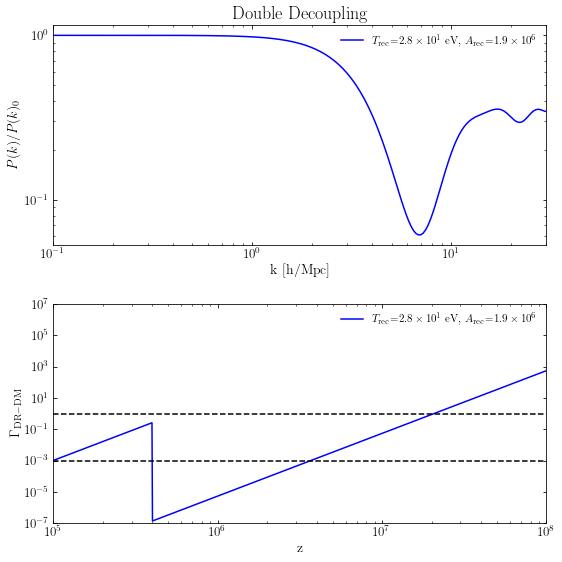

In [48]:
plot_varied_recoupling_strong(Tr0, Ar0, Tr1, Ar1, save=False)


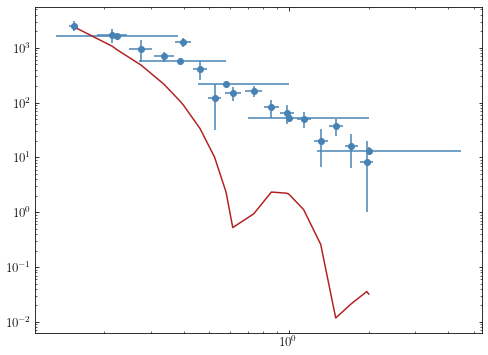

In [49]:
# plt.loglog(constraint_ks_sorted, constraint_pks_sorted, 'o')
plt.errorbar(constraint_ks_sorted, constraint_pks_sorted, yerr=constraint_pk_y_var_sorted, xerr=constraint_pk_x_var_sorted,fmt='o', label='Observations')
plt.loglog(constraint_ks_sorted, test_pks)
plt.show()

In [50]:
#new chi2_statistic
interpolating_function = interp1d(constraint_ks_sorted, test_pks, kind='cubic')
y_interp = interpolating_function(constraint_ks_sorted)
dx = np.gradient(constraint_ks_sorted)
dy_dx = np.gradient(y_interp, dx)

y_total_err = np.sqrt(constraint_pk_y_var_sorted**2 + (dy_dx * constraint_pk_x_var_sorted)**2)
chi2_new = np.sum((constraint_pks_sorted - y_interp)**2 / y_total_err**2)
p_value = 1.0 - chi2.cdf(chi2_new, len(constraint_ks_sorted))

print("Chi2:  ", chi2_new)
print("P-value: ", p_value)
if p_value < 0.05:
    print("Model does not fit data")
else:
    print("Model fits data")

Chi2:   231.30273432019933
P-value:  0.0
Model does not fit data


In [77]:
def make_constraint_chisquare():
    chi2_grid = np.zeros((N_points, N_points))

    for i, Tr in enumerate(T_rec_strong_arr):
        for j, Ar in enumerate(A_rec_strong_arr):
            # test_pks = np.array([pk_strong_interp((Tr, Ar, k)) for k in constraint_ks_sorted])
            # test_pks = np.array([pk_strong_interp_late((Tr, Ar, k)) for k in constraint_ks_sorted])
            test_pks = np.array([pk_strong_interp_n2((Tr, Ar, k)) for k in constraint_ks_sorted])

            interpolating_function = interp1d(constraint_ks_sorted, test_pks, kind='cubic')
            y_interp = interpolating_function(constraint_ks_sorted)
            dx = np.gradient(constraint_ks_sorted)
            dy_dx = np.gradient(y_interp, dx)
            y_total_err = np.sqrt(constraint_pk_y_var_sorted**2 + (dy_dx * constraint_pk_x_var_sorted)**2)
            chi2 = np.sum((constraint_pks_sorted - y_interp)**2 / y_total_err**2)
            chi2_grid[i, j] = chi2
    return chi2_grid

def make_constraint_grid_chisquare(chi2_grid):
    #crit_val = 36.42 #for 24 points
    crit_val = chi2.isf(0.05, len(constraint_ks_sorted))
    limit_grid = np.zeros((N_points, N_points))
    for i in range(N_points):
        for j in range(N_points):
            if chi2_grid[i, j] > crit_val:
                limit_grid[i, j] = 1
    return limit_grid



In [78]:
chi2_grid = make_constraint_chisquare()

In [79]:
limit_grid_chi2 = make_constraint_grid_chisquare(chi2_grid)

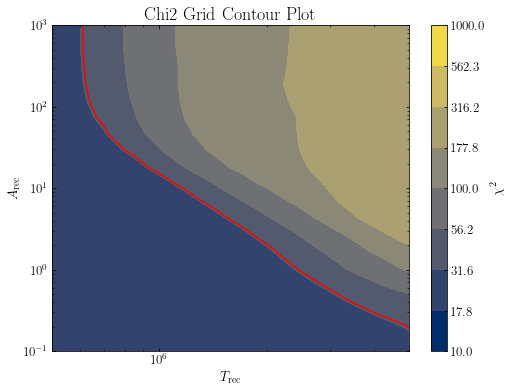

In [80]:
X, Y = np.meshgrid(T_rec_strong_arr, A_rec_strong_arr)

# Define the new grid
X_new = np.logspace(np.log10(X.min()), np.log10(X.max()), 40)  # 500 is the number of points for smoothing, adjust as needed
Y_new = np.logspace(np.log10(Y.min()), np.log10(Y.max()), 40)
X_new, Y_new = np.meshgrid(X_new, Y_new)

# Flatten your original data for the griddata function
points = np.array([X.flatten(), Y.flatten()]).T
values = chi2_grid.flatten()

# Perform the interpolation
chi2_grid_new = griddata(points, values, (X_new, Y_new), method='linear')

# Create the contour plot
plt.figure(figsize=(8, 6))
# plt.contourf(X_new, Y_new, chi2_grid_new, levels=np.logspace(np.log10(chi2_grid_new.min()),np.log10(chi2_grid_new.max()),7),norm=LogNorm(), cmap='cividis')
plt.contourf(X_new, Y_new, chi2_grid_new, levels=np.logspace(1,3,9),norm=LogNorm(), cmap='cividis')

cbar = plt.colorbar()
cbar.set_label(r'$\chi^2$')
plt.contour(X_new, Y_new, chi2_grid_new, levels=[chi2.isf(0.05, len(constraint_ks_sorted))], colors='red')

plt.xscale('log')
plt.yscale('log')
plt.xlim(5e5, 5e6)
plt.ylim(1e-1, 1e3)
plt.xlabel('$T_\mathrm{rec}$')
plt.ylabel('$A_\mathrm{rec}$')
plt.title('Chi2 Grid Contour Plot')
# plt.savefig('Figures/chi2_grid_contour_plot.pdf')
plt.show()

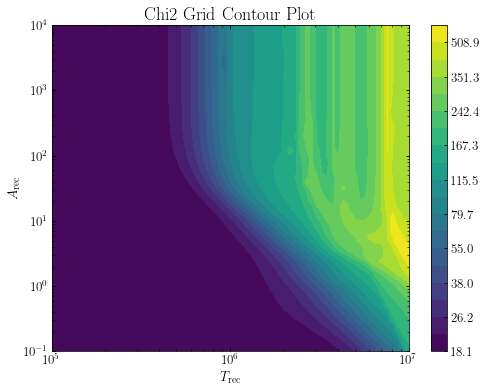

In [81]:
# Create a contour plot of the chi2_grid with logarithmic scale
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, chi2_grid, levels=np.logspace(np.log10(np.min(chi2_grid)),np.log10(np.max(chi2_grid)),20), 
             norm=LogNorm(), cmap='viridis')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e5, 1e7)
plt.ylim(1e-1, 1e4)
plt.xlabel('$T_\mathrm{rec}$')
plt.ylabel('$A_\mathrm{rec}$')
plt.title('Chi2 Grid Contour Plot')
plt.show()

Try Lambda CDM and see if it agrees with the constraints or if it's a recoupling issue.

In [30]:
dfLCDM = pd.read_csv(
            'output/lambdacdm00_pk.dat', header=None, names=["k", "P(k)"], skiprows=4, delimiter="\s+",
        )

In [31]:
lcdm_interp = UnivariateSpline(dfLCDM["k"], dfLCDM["P(k)"], s=0)
lcdm_pks = np.array([lcdm_interp(k) for k in constraint_ks_sorted])

In [32]:
print(np.sum((constraint_pks_sorted - test_pks)**2 / constraint_pk_y_var_sorted**2))
print(np.sum((constraint_pks_sorted - lcdm_pks)**2 / constraint_pk_y_var_sorted**2))

918.8024864905352
68.69320175424473


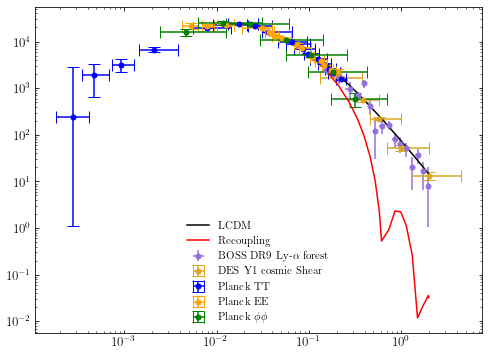

In [33]:
plt.errorbar(
    dfBOSS["X"],
    dfBOSS["Y"],
    yerr=yerrBOSS,
    xerr=xerrBOSS,
    marker="o",
    ms=5,
    color="mediumpurple",
    ls="none",
    label=r"BOSS DR9 Ly-$\alpha$ forest",
)

plt.errorbar(
    dfDES["X"],
    dfDES["Y"],
    yerr=yerrDES,
    xerr=xerrDES,
    marker="o",
    ms=5,
    color="goldenrod",
    ls="none",
    capsize=6,
    label="DES Y1 cosmic Shear",
)

plt.errorbar(
    dfPlanckTT["X"],
    dfPlanckTT["Y"],
    yerr=yerrTT,
    xerr=xerrTT,
    marker="o",
    ms=5,
    color="blue",
    ls="none",
    capsize=6,
    label="Planck TT",
)

plt.errorbar(
    dfPlanckEE["X"],
    dfPlanckEE["Y"],
    yerr=yerrEE,
    xerr=xerrEE,
    marker="o",
    ms=5,
    color="orange",
    ls="none",
    capsize=6,
    label="Planck EE",
)

plt.errorbar(
    dfPlanckPP["X"],
    dfPlanckPP["Y"],
    yerr=yerrPP,
    xerr=xerrPP,
    marker="o",
    ms=5,
    color="green",
    ls="none",
    capsize=6,
    label="Planck $\phi\phi$",
)

# plt.plot(constraint_ks_sorted, constraint_pks_sorted, color="black", label="Constraint")
# plt.errorbar(constraint_ks_sorted, constraint_pks_sorted, yerr=constraint_pk_y_errs_sorted, color="black", ls="none", alpha=0.5)
plt.plot(constraint_ks_sorted, lcdm_pks, color="black", label="LCDM")
plt.plot(constraint_ks_sorted, test_pks, color="red", label="Recoupling")

plt.xscale("log")
plt.yscale("log")

# plt.xlim(1e-2, 1e-1)
# plt.ylim(1e3, 5e4)
plt.legend()

plt.show()

Time from A_rec

In [123]:
z_data = np.geomspace(1e-3,1e8,int(1e5))

def recoupling_time_new(T_rec, A_rec):
    dmus = np.array([dmu_idm_dr(T_rec, A_rec, z, case="recoupling", nindex_idm_dr=2, a_idm_dr=1e1) for z in z_data])
    z_rec = T_rec/0.3/2.73
    rec_idx = np.argmin(abs(z_data - z_rec))
    dec_idx = np.argmax(dmus>1)
    if rec_idx <= dec_idx:
        return np.nan
    rec_duration_tau = thermo_taus_no_rec(z_data[dec_idx]).item() - thermo_taus_no_rec(z_data[rec_idx]).item()
    return rec_duration_tau

In [135]:
i = 60
Tr1 = T_rec_strong_arr[i]
Ar1 = A_rec_strong_arr[i]
dmus = np.array([dmu_idm_dr(Tr1, Ar1, z, case="recoupling", nindex_idm_dr=2, a_idm_dr=1e1) for z in z_data])


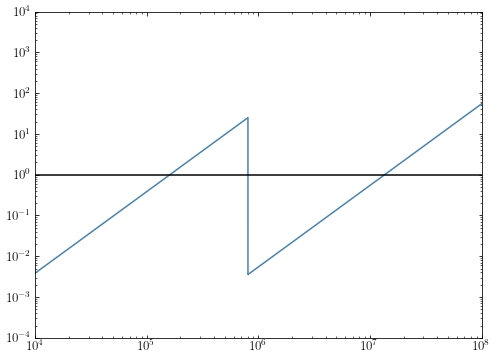

In [136]:
plt.loglog(z_data, dmus)
plt.xlim(1e4, 1e8)
plt.ylim(1e-4, 1e4)
plt.axhline(1, color="black")

plt.show()

In [130]:
rec_times = np.array([recoupling_time_new(A_rec_strong_arr[i], Tr1) for i in range(len(A_rec_strong_arr))])

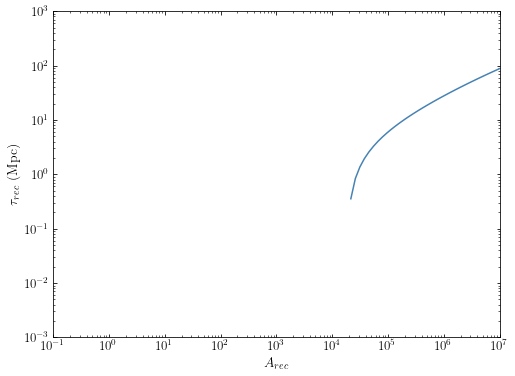

In [132]:
plt.plot(A_rec_strong_arr,rec_times)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$A_{rec}$")
plt.ylabel(r"$\tau_{rec}$ (Mpc)")
plt.ylim(1e-3, 1e3)
plt.xlim(min(A_rec_strong_arr), max(A_rec_strong_arr))
plt.show()

In [65]:
def calculate_tau_rec(params):
    T_rec, A_rec = params
    return recoupling_time_new(T_rec, A_rec)

In [75]:
params = list(itertools.product(T_rec_strong_arr, A_rec_strong_arr))

with Pool() as pool:
    results = pool.map(calculate_tau_rec, params)

tau_rec_grid = np.array(results).reshape(len(T_rec_strong_arr), len(A_rec_strong_arr))

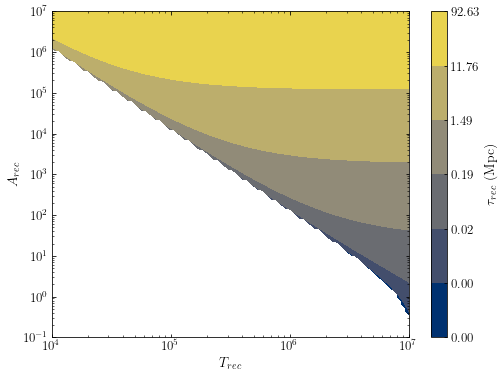

In [143]:
plt.contourf(X, Y, tau_rec_grid, levels=np.logspace(np.log10(np.nanmin(tau_rec_grid)), np.log10(np.nanmax(tau_rec_grid)), 7), norm=LogNorm(), cmap='cividis')
plt.colorbar(label=r"$\tau_{rec}$ (Mpc)")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$T_{rec}$")
plt.ylabel(r"$A_{rec}$")
plt.show()

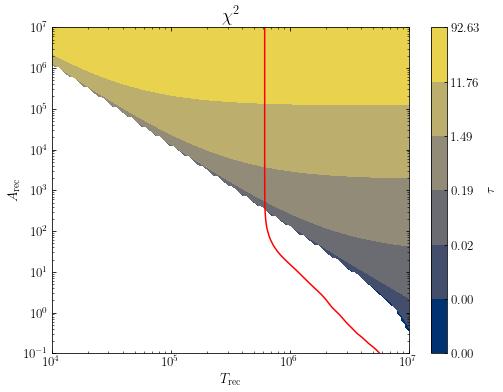

In [144]:
X, Y = np.meshgrid(T_rec_strong_arr, A_rec_strong_arr)

plt.contourf(X, Y, tau_rec_grid, levels=np.logspace(np.log10(np.nanmin(tau_rec_grid)), np.log10(np.nanmax(tau_rec_grid)), 7), norm=LogNorm(), cmap='cividis')

cbar = plt.colorbar()
cbar.set_label(r'$\tau$')
plt.contour(X, Y, chi2_grid, levels=[chi2.isf(0.05, len(constraint_ks_sorted))], colors='red')

plt.xscale('log')
plt.yscale('log')
# plt.xlim(5e5, 5e6)
# plt.ylim(1e-1, 1e3)
plt.xlabel('$T_\mathrm{rec}$')
# plt.ylabel(r'$\tau$')
plt.ylabel(r'$A_\mathrm{rec}$')
plt.title(r'$\chi^2$')
plt.show()


## Test which params to use for less steep power law

In [120]:
def plot_recoupling(Tr0, Ar0, Tr1, Ar1):
    """
    Plot the interpolation between two scenarios with varied 
    recoupling temperature and/or strength (1,2).
    Normalized to the first scenario (0), presumably no recoupling.
    """

    zs = np.logspace(4, 8, 1000)
    dmus1 = [dmu_idm_dr(Tr1, Ar1, z, case="recoupling", nindex_idm_dr=2, a_idm_dr=1e1) for z in zs]

    fig = plt.figure(1, figsize=(8, 8))
    plt.subplot(212)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("z")
    plt.ylabel("$\Gamma_{\mathrm{DR-DM}}$")
    plt.plot(
        zs,
        dmus1,
        "b",
        label="$T_\mathrm{rec}$=%s eV, $A_\mathrm{rec}$=%s"
        % (scientific_format(Tr1 * ktoev), scientific_format(Ar1)),
    )
    
    plt.plot(np.logspace(4, 8, 100), 1e-3 * np.ones(100), "--k")
    plt.plot(np.logspace(4, 8, 100), np.ones(100), "--k")

    plt.xlim(zs[0], zs[-1])
    plt.ylim(1e-7, 1e7)

    plt.legend()
    fig.tight_layout(h_pad=2)

    plt.show()


In [210]:
Tr1 = T_rec_strong_arr[60]
Ar1 = A_rec_strong_arr[99]
test_pks = np.zeros(len(constraint_ks_sorted))
for i, k in enumerate(constraint_ks_sorted):
    # test_pks[i] = pk_strong_interp((Tr1, Ar1, k))
    test_pks[i] = pk_strong_interp_late((Tr1, Ar1, k))


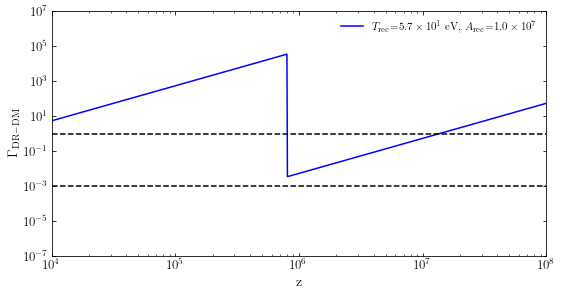

In [211]:
plot_recoupling(Tr0, Ar0, Tr1, Ar1)

In [250]:
def plot_varied_recoupling_strong(Tr0, Ar0, Tr1, Ar1, save=False):
    """
    Plot the interpolation between two scenarios with varied 
    recoupling temperature and/or strength (1,2).
    Normalized to the first scenario (0), presumably no recoupling.
    """

    zs = np.logspace(4, 8, 1000)
    # dmus1 = [dmu_idm_dr(Tr1, Ar1, z) for z in zs]
    dmus1 = [dmu_idm_dr(Tr1, Ar1, z, case="recoupling", nindex_idm_dr=2, a_idm_dr=1e1) for z in zs]


    fig = plt.figure(1, figsize=(8, 8))
    plt.subplot(211)
    plt.plot(
        kk,
        # pk_strong_interp((Tr1, Ar1, kk)) / pk_dd_interp((Tr0, Ar0, kk)),
        pk_strong_interp_n2((Tr1, Ar1, kk)) / pk_dd_interp((Tr0, Ar0, kk)),

        "b",
        label="$T_\mathrm{rec}$=%s eV, $A_\mathrm{rec}$=%s"
        % (scientific_format(Tr1 * ktoev), scientific_format(Ar1)),
    )
    
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(1e-1, 3e1)
    # plt.ylim(0.97, 1)
    plt.xlabel("k [h/Mpc]")
    plt.ylabel("$P(k)/P(k)_0$")
    plt.legend()
    plt.title("Double Decoupling")
    plt.subplot(212)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("z")
    plt.ylabel("$\Gamma_{\mathrm{DR-DM}}/ \mathcal{H}$")
    plt.plot(
        zs,
        dmus1/conformal_H(zs),
        "b",
        label="$T_\mathrm{rec}$=%s eV, $A_\mathrm{rec}$=%s"
        % (scientific_format(Tr1 * ktoev), scientific_format(Ar1)),
    )
    
    plt.plot(np.logspace(4, 8, 100), 1e-3 * np.ones(100), "--k")
    plt.plot(np.logspace(4, 8, 100), np.ones(100), "--k")

    plt.xlim(zs[0], zs[-1])
    plt.ylim(1e-7, 1e7)

    plt.legend()
    fig.tight_layout(h_pad=2)

    if save:
        plot_dir = "Figures/"
        filename = "varying_recoupling_strong_{:.1e}{:.1e}{:.1e}{:.1e}.pdf".format(
            Tr1, Ar1
        )

        plt.savefig(plot_dir + filename)
        plt.clf()
    else:
        plt.show()


In [262]:
N_points = 100
T_rec_arr = np.logspace(4, 7, N_points)
A_rec_arr = np.logspace(-1, 7, N_points)

Tr0 = 1e5
Ar0 = 0.1
Tr1 = T_rec_arr[10]
Ar1 = A_rec_arr[80]


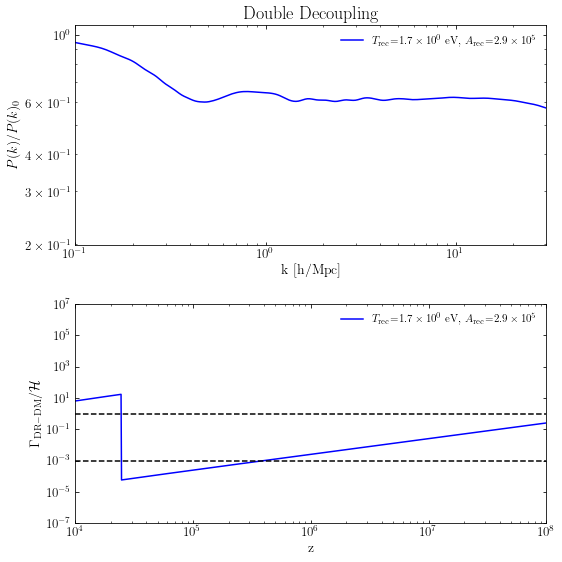

In [263]:
plot_varied_recoupling_strong(Tr0, Ar0, Tr1, Ar1, save=False)
